In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_dataset = pd.read_csv('data/train.csv')
predict_data = pd.read_csv('data/test.csv')

def get_categories(column): 
    value_dist = column.value_counts()
    outlier_threshold = 0.01 # 1% of recorded represented.  
    filt = value_dist > sum(value_dist) * outlier_threshold
    return list(value_dist[filt].index)

def get_map_function(column): # Strategy: get the average price per category, then list in that order
    column = pd.Series(column)
    
    map_values = get_categories(column)
    mapping_dictionary = {}
    
    for index, value in enumerate(column):
        if value in map_values:
            if value in mapping_dictionary:
                mapping_dictionary[value] = mapping_dictionary[value] + train_dataset['SalePrice'][index]
            elif not pd.isnull(value):
                mapping_dictionary[value] = train_dataset['SalePrice'][index]

    
    value_dist = column.value_counts()
    for key in mapping_dictionary:
        mapping_dictionary[key] = mapping_dictionary[key] / value_dist[key]
        
    mapping_dictionary = dict(sorted(mapping_dictionary.items(), key=lambda item: item[1]))
    
    zeros = -1
    for index, key in enumerate(mapping_dictionary):
        if mapping_dictionary[key] != 0:
            mapping_dictionary[key] = np.int64(index - zeros)
        else:
            zeros += 1
    # all values that are not in final dictionary converge to 0, so account for that in returned function
    return lambda x : mapping_dictionary[x] if not pd.isnull(x) and x in mapping_dictionary else 0


# Apply map function to convert string values to numerical
mapped_train = pd.DataFrame(train_dataset).copy()
for column in mapped_train:
    if mapped_train[column].dtype == np.object:        
        mapped_train[column] = mapped_train[column].apply(get_map_function(mapped_train[column]))
    else:
        mapped_train[column] = mapped_train[column].apply(lambda x : x if not pd.isnull(x) else 0)

mapped_train.drop('Id', axis=1, inplace=True)

# Remove any outliers

# remove_outliers(column: pd.Series): pd.Series # boolean (filter mask)
def remove_outliers_filter(df, column):
    z_scores = (df[column.name].values - np.mean(column))/np.std(column) # vectorized and has (1/100)x runtime :o
    filt = z_scores < 7
    return filt

filt = pd.Series(np.ones((mapped_train.shape[0]), dtype=bool))

for column in mapped_train:
    filt = np.logical_and(remove_outliers_filter(mapped_train, mapped_train[column]), filt)
    
mapped_train = mapped_train.loc[filt]

for column in predict_data:
    if predict_data[column].dtype == np.object:        
        predict_data[column] = predict_data[column].apply(get_map_function(predict_data[column]))
    else:
        predict_data[column] = predict_data[column].apply(lambda x : x if not pd.isnull(x) else 0)

predict_ids = predict_data['Id']
predict_data.drop('Id', axis=1, inplace=True)

Above functions were from previous notebooks

In [2]:
%timeit
# Create Train vectors, and label validation/test vectors

validation_set = mapped_train.sample(frac=1/5) # 80% train, 20% validation
train_set = mapped_train.copy().drop(validation_set.index)

train_y = train_set['SalePrice'].to_numpy()
train_x = train_set.drop('SalePrice', axis=1).to_numpy()

print(train_x.shape)

val_y = validation_set['SalePrice'].to_numpy()
val_x = validation_set.drop('SalePrice', axis=1).to_numpy()



(1130, 79)


In [3]:
from keras import Sequential
import keras
from keras import models, layers
from keras.layers import Dense, Activation, Dropout
import datetime

start = datetime.datetime.now()
model = Sequential()

model.add(Dense(train_x.shape[1])) # input vector size

model.add(Dense(79, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

print(train_x.shape)
print(train_y.shape)
model.fit(train_x, train_y, batch_size=64, epochs=2000, validation_data=(val_x, val_y))
print(f'Took {(datetime.datetime.now() - start)} (h:m:s:ms) to train.')

(1130, 79)
(1130,)
Epoch 1/2000
18/18 [==============================] - 1s 36ms/step - loss: 37810836318.3158 - val_loss: 33959204864.0000
Epoch 2/2000
18/18 [==============================] - 0s 4ms/step - loss: 34186575225.2632 - val_loss: 24908058624.0000
Epoch 3/2000
18/18 [==============================] - 0s 6ms/step - loss: 22172810078.3158 - val_loss: 8107983872.0000
Epoch 4/2000
18/18 [==============================] - 0s 4ms/step - loss: 8097923503.1579 - val_loss: 4374666752.0000
Epoch 5/2000
18/18 [==============================] - 0s 4ms/step - loss: 8303033317.0526 - val_loss: 4635261952.0000
Epoch 6/2000
18/18 [==============================] - 0s 5ms/step - loss: 7614177657.2632 - val_loss: 4191643904.0000
Epoch 7/2000
18/18 [==============================] - 0s 5ms/step - loss: 6992021396.2105 - val_loss: 3869937408.0000
Epoch 8/2000
18/18 [==============================] - 0s 5ms/step - loss: 5680043856.8421 - val_loss: 3664913408.0000
Epoch 9/2000
18/18 [===========

18/18 [==============================] - 0s 4ms/step - loss: 2529328983.5789 - val_loss: 1267849728.0000
Epoch 70/2000
18/18 [==============================] - 0s 5ms/step - loss: 2685258516.2105 - val_loss: 1253147776.0000
Epoch 71/2000
18/18 [==============================] - 0s 6ms/step - loss: 2587458701.4737 - val_loss: 1278795776.0000
Epoch 72/2000
18/18 [==============================] - 0s 8ms/step - loss: 2770048431.1579 - val_loss: 1241271680.0000
Epoch 73/2000
18/18 [==============================] - 0s 7ms/step - loss: 2762975555.3684 - val_loss: 1347204992.0000
Epoch 74/2000
18/18 [==============================] - 0s 17ms/step - loss: 2571435978.1053 - val_loss: 1231317632.0000
Epoch 75/2000
18/18 [==============================] - 0s 13ms/step - loss: 2480796806.7368 - val_loss: 1328928000.0000
Epoch 76/2000
18/18 [==============================] - 0s 13ms/step - loss: 2699455905.6842 - val_loss: 1222316800.0000
Epoch 77/2000
18/18 [==============================] - 0s 6

18/18 [==============================] - 0s 4ms/step - loss: 2898741706.1053 - val_loss: 1248381056.0000
Epoch 138/2000
18/18 [==============================] - 0s 4ms/step - loss: 2776471013.0526 - val_loss: 1176819584.0000
Epoch 139/2000
18/18 [==============================] - 0s 4ms/step - loss: 2620577468.6316 - val_loss: 1136276480.0000
Epoch 140/2000
18/18 [==============================] - 0s 4ms/step - loss: 2611244449.6842 - val_loss: 1247545216.0000
Epoch 141/2000
18/18 [==============================] - 0s 4ms/step - loss: 2662243031.5789 - val_loss: 1133850368.0000
Epoch 142/2000
18/18 [==============================] - 0s 4ms/step - loss: 2579658826.1053 - val_loss: 1289542784.0000
Epoch 143/2000
18/18 [==============================] - 0s 4ms/step - loss: 2605814460.6316 - val_loss: 1299734656.0000
Epoch 144/2000
18/18 [==============================] - 0s 4ms/step - loss: 2680786634.1053 - val_loss: 1198926848.0000
Epoch 145/2000
18/18 [==============================] -

18/18 [==============================] - 0s 4ms/step - loss: 2358193765.0526 - val_loss: 1086328960.0000
Epoch 206/2000
18/18 [==============================] - 0s 4ms/step - loss: 2520020217.2632 - val_loss: 1177547136.0000
Epoch 207/2000
18/18 [==============================] - 0s 4ms/step - loss: 2379406356.2105 - val_loss: 1446099456.0000
Epoch 208/2000
18/18 [==============================] - 0s 4ms/step - loss: 2689463915.7895 - val_loss: 1235363072.0000
Epoch 209/2000
18/18 [==============================] - 0s 4ms/step - loss: 2592461669.0526 - val_loss: 1115682304.0000
Epoch 210/2000
18/18 [==============================] - 0s 4ms/step - loss: 2597918989.4737 - val_loss: 1147780480.0000
Epoch 211/2000
18/18 [==============================] - 0s 4ms/step - loss: 2283243843.3684 - val_loss: 1167640192.0000
Epoch 212/2000
18/18 [==============================] - 0s 4ms/step - loss: 2460119013.0526 - val_loss: 1296117248.0000
Epoch 213/2000
18/18 [==============================] -

18/18 [==============================] - 0s 4ms/step - loss: 2220184697.2632 - val_loss: 1341643264.0000
Epoch 274/2000
18/18 [==============================] - 0s 4ms/step - loss: 2501648101.0526 - val_loss: 1106823936.0000
Epoch 275/2000
18/18 [==============================] - 0s 4ms/step - loss: 2390764665.2632 - val_loss: 1337058560.0000
Epoch 276/2000
18/18 [==============================] - 0s 4ms/step - loss: 2426428449.6842 - val_loss: 1181524992.0000
Epoch 277/2000
18/18 [==============================] - 0s 4ms/step - loss: 2621283691.7895 - val_loss: 1207739392.0000
Epoch 278/2000
18/18 [==============================] - 0s 4ms/step - loss: 2406057882.9474 - val_loss: 1037063488.0000
Epoch 279/2000
18/18 [==============================] - 0s 4ms/step - loss: 2541524412.6316 - val_loss: 1001944256.0000
Epoch 280/2000
18/18 [==============================] - 0s 4ms/step - loss: 2291981931.7895 - val_loss: 1000228544.0000
Epoch 281/2000
18/18 [==============================] -

18/18 [==============================] - 0s 4ms/step - loss: 2215711649.6842 - val_loss: 988706560.0000
Epoch 342/2000
18/18 [==============================] - 0s 4ms/step - loss: 2068556550.7368 - val_loss: 1089845888.0000
Epoch 343/2000
18/18 [==============================] - 0s 4ms/step - loss: 2084719703.5789 - val_loss: 1069245504.0000
Epoch 344/2000
18/18 [==============================] - 0s 4ms/step - loss: 2295452907.7895 - val_loss: 1159301120.0000
Epoch 345/2000
18/18 [==============================] - 0s 4ms/step - loss: 2322008070.7368 - val_loss: 1103770240.0000
Epoch 346/2000
18/18 [==============================] - 0s 4ms/step - loss: 2383798743.5789 - val_loss: 1368840704.0000
Epoch 347/2000
18/18 [==============================] - 0s 4ms/step - loss: 2353706509.4737 - val_loss: 1091804032.0000
Epoch 348/2000
18/18 [==============================] - 0s 4ms/step - loss: 2146481111.5789 - val_loss: 1045637248.0000
Epoch 349/2000
18/18 [==============================] - 

18/18 [==============================] - 0s 4ms/step - loss: 2054571237.0526 - val_loss: 1133746048.0000
Epoch 410/2000
18/18 [==============================] - 0s 4ms/step - loss: 2520102191.1579 - val_loss: 1322227712.0000
Epoch 411/2000
18/18 [==============================] - 0s 4ms/step - loss: 2262638760.4211 - val_loss: 1128547968.0000
Epoch 412/2000
18/18 [==============================] - 0s 4ms/step - loss: 2276652166.7368 - val_loss: 1209743744.0000
Epoch 413/2000
18/18 [==============================] - 0s 4ms/step - loss: 2528225792.0000 - val_loss: 1043997568.0000
Epoch 414/2000
18/18 [==============================] - 0s 4ms/step - loss: 2167061551.1579 - val_loss: 1096983680.0000
Epoch 415/2000
18/18 [==============================] - 0s 4ms/step - loss: 2222208619.7895 - val_loss: 1001292736.0000
Epoch 416/2000
18/18 [==============================] - 0s 4ms/step - loss: 2113775488.0000 - val_loss: 1198269312.0000
Epoch 417/2000
18/18 [==============================] -

18/18 [==============================] - 0s 4ms/step - loss: 1922274593.6842 - val_loss: 1360339840.0000
Epoch 478/2000
18/18 [==============================] - 0s 4ms/step - loss: 1970521047.5789 - val_loss: 1076054784.0000
Epoch 479/2000
18/18 [==============================] - 0s 4ms/step - loss: 2074575326.3158 - val_loss: 880358592.0000
Epoch 480/2000
18/18 [==============================] - 0s 4ms/step - loss: 2141573382.7368 - val_loss: 1187795840.0000
Epoch 481/2000
18/18 [==============================] - 0s 4ms/step - loss: 1989467823.1579 - val_loss: 1246698624.0000
Epoch 482/2000
18/18 [==============================] - 0s 4ms/step - loss: 2022369785.2632 - val_loss: 1653052800.0000
Epoch 483/2000
18/18 [==============================] - 0s 4ms/step - loss: 1999690051.3684 - val_loss: 1208110848.0000
Epoch 484/2000
18/18 [==============================] - 0s 4ms/step - loss: 1995717146.9474 - val_loss: 1214564352.0000
Epoch 485/2000
18/18 [==============================] - 

18/18 [==============================] - 0s 5ms/step - loss: 2165508500.2105 - val_loss: 1257985024.0000
Epoch 546/2000
18/18 [==============================] - 0s 4ms/step - loss: 1760148122.9474 - val_loss: 1517135744.0000
Epoch 547/2000
18/18 [==============================] - 0s 4ms/step - loss: 1801154068.2105 - val_loss: 1071054592.0000
Epoch 548/2000
18/18 [==============================] - 0s 4ms/step - loss: 2032594485.8947 - val_loss: 1259031424.0000
Epoch 549/2000
18/18 [==============================] - 0s 4ms/step - loss: 2066996823.5789 - val_loss: 1323363200.0000
Epoch 550/2000
18/18 [==============================] - 0s 4ms/step - loss: 2035771270.7368 - val_loss: 954031808.0000
Epoch 551/2000
18/18 [==============================] - 0s 4ms/step - loss: 2039620318.3158 - val_loss: 991590016.0000
Epoch 552/2000
18/18 [==============================] - 0s 4ms/step - loss: 1949984666.9474 - val_loss: 927870336.0000
Epoch 553/2000
18/18 [==============================] - 0s

18/18 [==============================] - 0s 4ms/step - loss: 1826355152.8421 - val_loss: 1598784896.0000
Epoch 614/2000
18/18 [==============================] - 0s 4ms/step - loss: 2074805234.5263 - val_loss: 1441401344.0000
Epoch 615/2000
18/18 [==============================] - 0s 4ms/step - loss: 2073955853.4737 - val_loss: 1289561984.0000
Epoch 616/2000
18/18 [==============================] - 0s 4ms/step - loss: 2321333793.6842 - val_loss: 1038498112.0000
Epoch 617/2000
18/18 [==============================] - 0s 4ms/step - loss: 1888043634.5263 - val_loss: 1632558336.0000
Epoch 618/2000
18/18 [==============================] - 0s 4ms/step - loss: 2109292759.5789 - val_loss: 1287561984.0000
Epoch 619/2000
18/18 [==============================] - 0s 4ms/step - loss: 2017435223.5789 - val_loss: 1329611520.0000
Epoch 620/2000
18/18 [==============================] - 0s 4ms/step - loss: 1630935929.2632 - val_loss: 1557909120.0000
Epoch 621/2000
18/18 [==============================] -

18/18 [==============================] - 0s 4ms/step - loss: 1792414713.2632 - val_loss: 865753728.0000
Epoch 682/2000
18/18 [==============================] - 0s 4ms/step - loss: 1755071558.7368 - val_loss: 1094710144.0000
Epoch 683/2000
18/18 [==============================] - 0s 4ms/step - loss: 1822866964.2105 - val_loss: 1350826240.0000
Epoch 684/2000
18/18 [==============================] - 0s 4ms/step - loss: 1703181561.2632 - val_loss: 1090715648.0000
Epoch 685/2000
18/18 [==============================] - 0s 4ms/step - loss: 1687912454.7368 - val_loss: 1561319424.0000
Epoch 686/2000
18/18 [==============================] - 0s 4ms/step - loss: 1689188136.4211 - val_loss: 1016984192.0000
Epoch 687/2000
18/18 [==============================] - 0s 4ms/step - loss: 2029155233.6842 - val_loss: 1219476992.0000
Epoch 688/2000
18/18 [==============================] - 0s 4ms/step - loss: 1821475422.3158 - val_loss: 1171623040.0000
Epoch 689/2000
18/18 [==============================] - 

18/18 [==============================] - 0s 4ms/step - loss: 1630560889.2632 - val_loss: 1349070336.0000
Epoch 750/2000
18/18 [==============================] - 0s 4ms/step - loss: 1869245345.6842 - val_loss: 911648000.0000
Epoch 751/2000
18/18 [==============================] - 0s 4ms/step - loss: 1793570445.4737 - val_loss: 991574656.0000
Epoch 752/2000
18/18 [==============================] - 0s 4ms/step - loss: 1831605820.6316 - val_loss: 1271312384.0000
Epoch 753/2000
18/18 [==============================] - 0s 4ms/step - loss: 1794890314.1053 - val_loss: 1157097856.0000
Epoch 754/2000
18/18 [==============================] - 0s 4ms/step - loss: 1712834297.2632 - val_loss: 1036540992.0000
Epoch 755/2000
18/18 [==============================] - 0s 4ms/step - loss: 1799265360.8421 - val_loss: 1308748032.0000
Epoch 756/2000
18/18 [==============================] - 0s 4ms/step - loss: 1527173376.0000 - val_loss: 2212692480.0000
Epoch 757/2000
18/18 [==============================] - 0

18/18 [==============================] - 0s 4ms/step - loss: 1972765264.8421 - val_loss: 1128781952.0000
Epoch 818/2000
18/18 [==============================] - 0s 4ms/step - loss: 2111510406.7368 - val_loss: 1389508992.0000
Epoch 819/2000
18/18 [==============================] - 0s 4ms/step - loss: 1711342544.8421 - val_loss: 1229723264.0000
Epoch 820/2000
18/18 [==============================] - 0s 4ms/step - loss: 1921061928.4211 - val_loss: 1207574784.0000
Epoch 821/2000
18/18 [==============================] - 0s 4ms/step - loss: 2016065434.9474 - val_loss: 1376005888.0000
Epoch 822/2000
18/18 [==============================] - 0s 4ms/step - loss: 1559695878.7368 - val_loss: 1433003904.0000
Epoch 823/2000
18/18 [==============================] - 0s 4ms/step - loss: 1946847663.1579 - val_loss: 1339225088.0000
Epoch 824/2000
18/18 [==============================] - 0s 4ms/step - loss: 1763358053.0526 - val_loss: 947331520.0000
Epoch 825/2000
18/18 [==============================] - 

18/18 [==============================] - 0s 4ms/step - loss: 1950586374.7368 - val_loss: 1281786880.0000
Epoch 886/2000
18/18 [==============================] - 0s 4ms/step - loss: 1711839784.4211 - val_loss: 1602053632.0000
Epoch 887/2000
18/18 [==============================] - 0s 8ms/step - loss: 1611139179.7895 - val_loss: 1572492800.0000
Epoch 888/2000
18/18 [==============================] - 0s 4ms/step - loss: 1601672239.1579 - val_loss: 794037952.0000
Epoch 889/2000
18/18 [==============================] - 0s 4ms/step - loss: 1436624690.5263 - val_loss: 1125879296.0000
Epoch 890/2000
18/18 [==============================] - 0s 4ms/step - loss: 1985319228.6316 - val_loss: 1625410176.0000
Epoch 891/2000
18/18 [==============================] - 0s 4ms/step - loss: 1944783676.6316 - val_loss: 797633920.0000
Epoch 892/2000
18/18 [==============================] - 0s 4ms/step - loss: 1594603344.8421 - val_loss: 842445440.0000
Epoch 893/2000
18/18 [==============================] - 0s

18/18 [==============================] - 0s 4ms/step - loss: 1599416710.7368 - val_loss: 1162179712.0000
Epoch 954/2000
18/18 [==============================] - 0s 4ms/step - loss: 1703231110.7368 - val_loss: 913636352.0000
Epoch 955/2000
18/18 [==============================] - 0s 4ms/step - loss: 1759521428.2105 - val_loss: 985393600.0000
Epoch 956/2000
18/18 [==============================] - 0s 4ms/step - loss: 1537133406.3158 - val_loss: 853667520.0000
Epoch 957/2000
18/18 [==============================] - 0s 4ms/step - loss: 1850274216.4211 - val_loss: 1208678784.0000
Epoch 958/2000
18/18 [==============================] - 0s 4ms/step - loss: 1669708429.4737 - val_loss: 1167422080.0000
Epoch 959/2000
18/18 [==============================] - 0s 4ms/step - loss: 1925544818.5263 - val_loss: 2201661696.0000
Epoch 960/2000
18/18 [==============================] - 0s 4ms/step - loss: 1659653510.7368 - val_loss: 1085086464.0000
Epoch 961/2000
18/18 [==============================] - 0s

18/18 [==============================] - 0s 4ms/step - loss: 1955151164.6316 - val_loss: 1174457216.0000
Epoch 1022/2000
18/18 [==============================] - 0s 4ms/step - loss: 1651065438.3158 - val_loss: 1109526144.0000
Epoch 1023/2000
18/18 [==============================] - 0s 4ms/step - loss: 1785461820.6316 - val_loss: 846438080.0000
Epoch 1024/2000
18/18 [==============================] - 0s 4ms/step - loss: 2108730772.2105 - val_loss: 1231391488.0000
Epoch 1025/2000
18/18 [==============================] - 0s 4ms/step - loss: 1665869952.0000 - val_loss: 1473052672.0000
Epoch 1026/2000
18/18 [==============================] - 0s 4ms/step - loss: 1810800074.1053 - val_loss: 1141564672.0000
Epoch 1027/2000
18/18 [==============================] - 0s 4ms/step - loss: 1499087757.4737 - val_loss: 1436437632.0000
Epoch 1028/2000
18/18 [==============================] - 0s 4ms/step - loss: 1723597999.1579 - val_loss: 1361886208.0000
Epoch 1029/2000
18/18 [==========================

18/18 [==============================] - 0s 4ms/step - loss: 2268512437.8947 - val_loss: 1315721088.0000
Epoch 1090/2000
18/18 [==============================] - 0s 4ms/step - loss: 1613976912.8421 - val_loss: 1905257088.0000
Epoch 1091/2000
18/18 [==============================] - 0s 4ms/step - loss: 1765456000.0000 - val_loss: 1264596992.0000
Epoch 1092/2000
18/18 [==============================] - 0s 4ms/step - loss: 1891666950.7368 - val_loss: 1434182272.0000
Epoch 1093/2000
18/18 [==============================] - 0s 4ms/step - loss: 1710458799.1579 - val_loss: 1025420160.0000
Epoch 1094/2000
18/18 [==============================] - 0s 4ms/step - loss: 1676434869.8947 - val_loss: 902901312.0000
Epoch 1095/2000
18/18 [==============================] - 0s 4ms/step - loss: 1508435462.7368 - val_loss: 838187008.0000
Epoch 1096/2000
18/18 [==============================] - 0s 4ms/step - loss: 1930676042.1053 - val_loss: 896225024.0000
Epoch 1097/2000
18/18 [============================

Epoch 1157/2000
18/18 [==============================] - 0s 4ms/step - loss: 1723587880.4211 - val_loss: 1341263616.0000
Epoch 1158/2000
18/18 [==============================] - 0s 4ms/step - loss: 1730554273.6842 - val_loss: 1218431616.0000
Epoch 1159/2000
18/18 [==============================] - 0s 4ms/step - loss: 1747080346.9474 - val_loss: 2055952640.0000
Epoch 1160/2000
18/18 [==============================] - 0s 4ms/step - loss: 1644140133.0526 - val_loss: 1616005760.0000
Epoch 1161/2000
18/18 [==============================] - 0s 4ms/step - loss: 1745031828.2105 - val_loss: 960001984.0000
Epoch 1162/2000
18/18 [==============================] - 0s 3ms/step - loss: 2054343969.6842 - val_loss: 1400979712.0000
Epoch 1163/2000
18/18 [==============================] - 0s 4ms/step - loss: 1724939317.8947 - val_loss: 1329059328.0000
Epoch 1164/2000
18/18 [==============================] - 0s 4ms/step - loss: 1730601741.4737 - val_loss: 867253952.0000
Epoch 1165/2000
18/18 [===========

18/18 [==============================] - 0s 8ms/step - loss: 1642823760.8421 - val_loss: 1145821952.0000
Epoch 1225/2000
18/18 [==============================] - 0s 6ms/step - loss: 1451285029.0526 - val_loss: 1376531200.0000
Epoch 1226/2000
18/18 [==============================] - 0s 4ms/step - loss: 1427964954.9474 - val_loss: 1103783808.0000
Epoch 1227/2000
18/18 [==============================] - 0s 4ms/step - loss: 2038706627.3684 - val_loss: 758213248.0000
Epoch 1228/2000
18/18 [==============================] - 0s 6ms/step - loss: 1712278002.5263 - val_loss: 1580963840.0000
Epoch 1229/2000
18/18 [==============================] - 0s 5ms/step - loss: 1909390612.2105 - val_loss: 1479334400.0000
Epoch 1230/2000
18/18 [==============================] - 0s 12ms/step - loss: 1734831420.6316 - val_loss: 1323466496.0000
Epoch 1231/2000
18/18 [==============================] - 0s 7ms/step - loss: 1696118022.7368 - val_loss: 1177646080.0000
Epoch 1232/2000
18/18 [=========================

Epoch 1292/2000
18/18 [==============================] - 0s 3ms/step - loss: 1774011311.1579 - val_loss: 700851456.0000
Epoch 1293/2000
18/18 [==============================] - 0s 3ms/step - loss: 1703257256.4211 - val_loss: 985981696.0000
Epoch 1294/2000
18/18 [==============================] - 0s 3ms/step - loss: 1675567205.0526 - val_loss: 1465202432.0000
Epoch 1295/2000
18/18 [==============================] - 0s 3ms/step - loss: 1505250041.2632 - val_loss: 1499081856.0000
Epoch 1296/2000
18/18 [==============================] - 0s 4ms/step - loss: 1860929697.6842 - val_loss: 1150916992.0000
Epoch 1297/2000
18/18 [==============================] - 0s 4ms/step - loss: 1804659920.8421 - val_loss: 885486208.0000
Epoch 1298/2000
18/18 [==============================] - 0s 4ms/step - loss: 1515180429.4737 - val_loss: 1357549696.0000
Epoch 1299/2000
18/18 [==============================] - 0s 4ms/step - loss: 1723820752.8421 - val_loss: 808313216.0000
Epoch 1300/2000
18/18 [=============

Epoch 1360/2000
18/18 [==============================] - 0s 3ms/step - loss: 1586236011.7895 - val_loss: 1301616768.0000
Epoch 1361/2000
18/18 [==============================] - 0s 4ms/step - loss: 1684163051.7895 - val_loss: 1059733184.0000
Epoch 1362/2000
18/18 [==============================] - 0s 6ms/step - loss: 1806442421.8947 - val_loss: 990134528.0000
Epoch 1363/2000
18/18 [==============================] - 0s 5ms/step - loss: 1368168677.0526 - val_loss: 1776358784.0000
Epoch 1364/2000
18/18 [==============================] - 0s 4ms/step - loss: 1689290482.5263 - val_loss: 973512768.0000
Epoch 1365/2000
18/18 [==============================] - 0s 4ms/step - loss: 2014724069.0526 - val_loss: 1086734976.0000
Epoch 1366/2000
18/18 [==============================] - 0s 4ms/step - loss: 1443186236.6316 - val_loss: 1034021440.0000
Epoch 1367/2000
18/18 [==============================] - 0s 4ms/step - loss: 1610512336.8421 - val_loss: 1019811648.0000
Epoch 1368/2000
18/18 [===========

Epoch 1428/2000
18/18 [==============================] - 0s 5ms/step - loss: 1448522125.4737 - val_loss: 957659328.0000
Epoch 1429/2000
18/18 [==============================] - 0s 7ms/step - loss: 1860994243.3684 - val_loss: 932547520.0000
Epoch 1430/2000
18/18 [==============================] - 0s 6ms/step - loss: 1609137529.2632 - val_loss: 730182912.0000
Epoch 1431/2000
18/18 [==============================] - 0s 6ms/step - loss: 1607016198.7368 - val_loss: 1229318656.0000
Epoch 1432/2000
18/18 [==============================] - 0s 5ms/step - loss: 1714789520.8421 - val_loss: 1275926272.0000
Epoch 1433/2000
18/18 [==============================] - 0s 4ms/step - loss: 1442213328.8421 - val_loss: 1756679680.0000
Epoch 1434/2000
18/18 [==============================] - 0s 7ms/step - loss: 1544558848.0000 - val_loss: 1329318144.0000
Epoch 1435/2000
18/18 [==============================] - 0s 10ms/step - loss: 1911169084.6316 - val_loss: 1101351808.0000
Epoch 1436/2000
18/18 [===========

Epoch 1496/2000
18/18 [==============================] - 0s 3ms/step - loss: 1867470928.8421 - val_loss: 1022264320.0000
Epoch 1497/2000
18/18 [==============================] - 0s 3ms/step - loss: 1846460382.3158 - val_loss: 989794304.0000
Epoch 1498/2000
18/18 [==============================] - 0s 3ms/step - loss: 1565061376.0000 - val_loss: 1115998592.0000
Epoch 1499/2000
18/18 [==============================] - 0s 4ms/step - loss: 1923807845.0526 - val_loss: 1196720640.0000
Epoch 1500/2000
18/18 [==============================] - 0s 4ms/step - loss: 1501906654.3158 - val_loss: 1783170176.0000
Epoch 1501/2000
18/18 [==============================] - 0s 4ms/step - loss: 2031116416.0000 - val_loss: 1678590720.0000
Epoch 1502/2000
18/18 [==============================] - 0s 4ms/step - loss: 1654658701.4737 - val_loss: 801774784.0000
Epoch 1503/2000
18/18 [==============================] - 0s 3ms/step - loss: 1696528821.8947 - val_loss: 688831616.0000
Epoch 1504/2000
18/18 [============

Epoch 1564/2000
18/18 [==============================] - 0s 8ms/step - loss: 1558561468.6316 - val_loss: 1371517696.0000
Epoch 1565/2000
18/18 [==============================] - 0s 7ms/step - loss: 1849964968.4211 - val_loss: 1354500608.0000
Epoch 1566/2000
18/18 [==============================] - 0s 6ms/step - loss: 1853613082.9474 - val_loss: 2002011392.0000
Epoch 1567/2000
18/18 [==============================] - 0s 5ms/step - loss: 1730024912.8421 - val_loss: 1567935616.0000
Epoch 1568/2000
18/18 [==============================] - 0s 7ms/step - loss: 1746906650.9474 - val_loss: 927917888.0000
Epoch 1569/2000
18/18 [==============================] - 0s 6ms/step - loss: 1821359797.8947 - val_loss: 1228372352.0000
Epoch 1570/2000
18/18 [==============================] - 0s 4ms/step - loss: 1734225313.6842 - val_loss: 1482698496.0000
Epoch 1571/2000
18/18 [==============================] - 0s 5ms/step - loss: 1816407060.2105 - val_loss: 1209031168.0000
Epoch 1572/2000
18/18 [==========

Epoch 1632/2000
18/18 [==============================] - 0s 4ms/step - loss: 1861657317.0526 - val_loss: 924084480.0000
Epoch 1633/2000
18/18 [==============================] - 0s 4ms/step - loss: 1890601781.8947 - val_loss: 1418325504.0000
Epoch 1634/2000
18/18 [==============================] - 0s 3ms/step - loss: 1644371065.2632 - val_loss: 1023886272.0000
Epoch 1635/2000
18/18 [==============================] - 0s 3ms/step - loss: 1528993455.1579 - val_loss: 1460420608.0000
Epoch 1636/2000
18/18 [==============================] - 0s 3ms/step - loss: 1669099459.3684 - val_loss: 1573144448.0000
Epoch 1637/2000
18/18 [==============================] - 0s 3ms/step - loss: 1741549440.0000 - val_loss: 1237632384.0000
Epoch 1638/2000
18/18 [==============================] - 0s 4ms/step - loss: 1727400218.9474 - val_loss: 764288704.0000
Epoch 1639/2000
18/18 [==============================] - 0s 3ms/step - loss: 1669896266.1053 - val_loss: 747954176.0000
Epoch 1640/2000
18/18 [============

Epoch 1700/2000
18/18 [==============================] - 0s 4ms/step - loss: 1535831215.1579 - val_loss: 1512986880.0000
Epoch 1701/2000
18/18 [==============================] - 0s 3ms/step - loss: 1698385050.9474 - val_loss: 1122624128.0000
Epoch 1702/2000
18/18 [==============================] - 0s 3ms/step - loss: 1843930846.3158 - val_loss: 1058203200.0000
Epoch 1703/2000
18/18 [==============================] - 0s 3ms/step - loss: 1430581537.6842 - val_loss: 886718656.0000
Epoch 1704/2000
18/18 [==============================] - 0s 3ms/step - loss: 1924394597.0526 - val_loss: 823452608.0000
Epoch 1705/2000
18/18 [==============================] - 0s 5ms/step - loss: 1876817973.8947 - val_loss: 1190763008.0000
Epoch 1706/2000
18/18 [==============================] - 0s 8ms/step - loss: 1442150581.8947 - val_loss: 1140904064.0000
Epoch 1707/2000
18/18 [==============================] - 0s 5ms/step - loss: 1599982005.8947 - val_loss: 1149628288.0000
Epoch 1708/2000
18/18 [===========

Epoch 1768/2000
18/18 [==============================] - 0s 4ms/step - loss: 1559041448.4211 - val_loss: 1473107968.0000
Epoch 1769/2000
18/18 [==============================] - 0s 3ms/step - loss: 1683798682.9474 - val_loss: 1724163200.0000
Epoch 1770/2000
18/18 [==============================] - 0s 4ms/step - loss: 1755260112.8421 - val_loss: 745067968.0000
Epoch 1771/2000
18/18 [==============================] - 0s 3ms/step - loss: 1746621682.5263 - val_loss: 1558009216.0000
Epoch 1772/2000
18/18 [==============================] - 0s 3ms/step - loss: 1848161327.1579 - val_loss: 937767488.0000
Epoch 1773/2000
18/18 [==============================] - 0s 3ms/step - loss: 1743195594.1053 - val_loss: 625197120.0000
Epoch 1774/2000
18/18 [==============================] - 0s 3ms/step - loss: 1582338654.3158 - val_loss: 968013376.0000
Epoch 1775/2000
18/18 [==============================] - 0s 3ms/step - loss: 1484516156.6316 - val_loss: 1611580928.0000
Epoch 1776/2000
18/18 [=============

Epoch 1836/2000
18/18 [==============================] - 0s 3ms/step - loss: 1666179078.7368 - val_loss: 1376905728.0000
Epoch 1837/2000
18/18 [==============================] - 0s 3ms/step - loss: 2124096747.7895 - val_loss: 625333760.0000
Epoch 1838/2000
18/18 [==============================] - 0s 3ms/step - loss: 2028422554.9474 - val_loss: 788296192.0000
Epoch 1839/2000
18/18 [==============================] - 0s 3ms/step - loss: 1553724186.9474 - val_loss: 1286650112.0000
Epoch 1840/2000
18/18 [==============================] - 0s 3ms/step - loss: 1879174581.8947 - val_loss: 985650880.0000
Epoch 1841/2000
18/18 [==============================] - 0s 3ms/step - loss: 1704104670.3158 - val_loss: 904287488.0000
Epoch 1842/2000
18/18 [==============================] - 0s 3ms/step - loss: 1544603486.3158 - val_loss: 1127925632.0000
Epoch 1843/2000
18/18 [==============================] - 0s 3ms/step - loss: 1805642125.4737 - val_loss: 795652544.0000
Epoch 1844/2000
18/18 [==============

Epoch 1904/2000
18/18 [==============================] - 0s 3ms/step - loss: 1553135232.0000 - val_loss: 1293203456.0000
Epoch 1905/2000
18/18 [==============================] - 0s 3ms/step - loss: 1769330425.2632 - val_loss: 1085258752.0000
Epoch 1906/2000
18/18 [==============================] - 0s 3ms/step - loss: 1544776751.1579 - val_loss: 1013727552.0000
Epoch 1907/2000
18/18 [==============================] - 0s 3ms/step - loss: 1906484372.2105 - val_loss: 1145924480.0000
Epoch 1908/2000
18/18 [==============================] - 0s 3ms/step - loss: 1915322327.5789 - val_loss: 726346752.0000
Epoch 1909/2000
18/18 [==============================] - 0s 3ms/step - loss: 1957933446.7368 - val_loss: 1150497408.0000
Epoch 1910/2000
18/18 [==============================] - 0s 3ms/step - loss: 1830476011.7895 - val_loss: 1333673984.0000
Epoch 1911/2000
18/18 [==============================] - 0s 3ms/step - loss: 1901814164.2105 - val_loss: 687071808.0000
Epoch 1912/2000
18/18 [===========

Epoch 1972/2000
18/18 [==============================] - 0s 3ms/step - loss: 1837492028.6316 - val_loss: 1641275648.0000
Epoch 1973/2000
18/18 [==============================] - 0s 3ms/step - loss: 1706403799.5789 - val_loss: 1115681536.0000
Epoch 1974/2000
18/18 [==============================] - 0s 3ms/step - loss: 1738004446.3158 - val_loss: 1205213312.0000
Epoch 1975/2000
18/18 [==============================] - 0s 4ms/step - loss: 1645708833.6842 - val_loss: 1764364416.0000
Epoch 1976/2000
18/18 [==============================] - 0s 4ms/step - loss: 1446802930.5263 - val_loss: 1283277952.0000
Epoch 1977/2000
18/18 [==============================] - 0s 3ms/step - loss: 1732672491.7895 - val_loss: 639675968.0000
Epoch 1978/2000
18/18 [==============================] - 0s 3ms/step - loss: 1743735309.4737 - val_loss: 1318610304.0000
Epoch 1979/2000
18/18 [==============================] - 0s 3ms/step - loss: 1719069766.7368 - val_loss: 1625129856.0000
Epoch 1980/2000
18/18 [==========

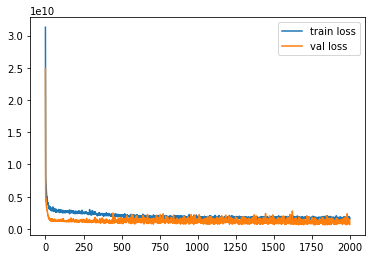

In [4]:
model.history.history
plt.plot(model.history.history['loss'][1:], label='train loss')
plt.plot(model.history.history['val_loss'][1:], label='val loss')
plt.legend()
plt.show()


In [5]:
def predict(vector):
    prediction = model.predict(vector.reshape((1,) + vector.shape))[0][0]
    return prediction
start = datetime.datetime.now()
result = pd.Series([predict(row) for row in predict_data.to_numpy()])
print(f'Took {datetime.datetime.now() - start} to run predictions.')



Took 0:00:58.971672 to run predictions.


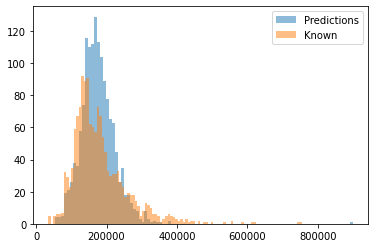

In [6]:
plt.hist(result, label='Predictions', bins=100, alpha=0.5)
plt.hist(train_dataset['SalePrice'], label='Known', bins=100, alpha=0.5)
plt.legend()
# plt.show()

submission = pd.DataFrame({'Id': predict_ids, 'SalePrice': result})
submission.to_csv('prediction_submission.csv', index=False)


Occured to me that I should see predictions on the training validation dataset

In [14]:
result_2 = pd.Series([predict(row) for row in val_x])
result_3 = pd.Series([predict(row) for row in train_x]) 

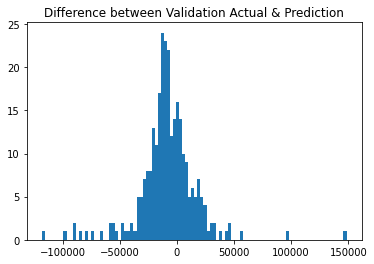

count       282.000000
mean      -8200.906652
std       25141.992227
min     -117852.078125
25%      -17690.367188
50%       -8680.582031
75%        2666.171875
max      148456.562500
dtype: float64
median 	 -8680.58203125


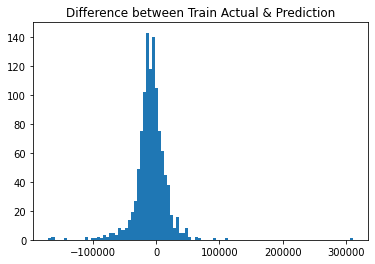

count      1130.000000
mean      -8572.091629
std       25373.693073
min     -170792.000000
25%      -18861.289062
50%       -8117.035156
75%        2905.576172
max      311128.031250
dtype: float64
median 	 -8117.03515625


In [28]:
difference = np.subtract(result_2, val_y)
plt.hist(difference, bins=100)
plt.title('Difference between Validation Actual & Prediction')
plt.show()
print(difference.describe())
print(f'median \t {difference.median()}')
difference = np.subtract(result_3, train_y)
plt.hist(difference, bins=100)
plt.title('Difference between Train Actual & Prediction')
plt.show()
print(difference.describe())
print(f'median \t {difference.median()}')

This is a really dumb idea, but as we can see, we are off by negative 8000.  What if we shift all of our predictions up by 8000? Will this decrease our MSE on the kaggle leaderboard??

In [27]:
# result_4 = result + 8500
# submission = pd.DataFrame({'Id': predict_ids, 'SalePrice': result_4})
# submission.to_csv('prediction_submission.csv', index=False)

I'm relieved, it does not work :)